In [1]:
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library(quantreg)
library("lubridate")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: SparseM


Attaching package: ‘SparseM’


The following object is masked from ‘package:base’:

    backsolve



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [5]:
######################
# Statewide analysis #
######################
# Here we show the following
# 1. Raw statewide death counts
# 2. Normalized statewide death counts
# 3. Relative contribution from each state
# California	0.12407822
# `New York City`	0.11347172
# Florida	0.06615664
# Texas	0.06427249
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]

# Read data from 2014-2019
us_death_old = read.csv("../data/Weekly_Counts_of_Deaths_by_State_and_Select_Causes__2014-2019.csv")
us_death_old$Week.Ending.Date = mdy(us_death_old$Week.Ending.Date)
us_death_old = us_death_old[!is.na(us_death_old$All..Cause) & !is.na(us_death_old$Week.Ending.Date), ]
us_death_old$Total.Deaths = us_death_old$All..Cause
us_death_old$data_set = "2014-2019"
us_death$data_set = "2020-2021"
us_death_old$State = us_death_old$Jurisdiction.of.Occurrence
us_death_all = rbind(us_death_old[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week", "State")], 
                                  us_death[,c("Week.Ending.Date", "Total.Deaths", "data_set", "MMWR.Week", "State")])
colnames(us_death)

[1] "Data.as.of"                              
 [2] "Start.Date"                              
 [3] "End.Date"                                
 [4] "Group"                                   
 [5] "Year"                                    
 [6] "Month"                                   
 [7] "MMWR.Week"                               
 [8] "Week.Ending.Date"                        
 [9] "State"                                   
[10] "COVID.19.Deaths"                         
[11] "Total.Deaths"                            
[12] "Percent.of.Expected.Deaths"              
[13] "Pneumonia.Deaths"                        
[14] "Pneumonia.and.COVID.19.Deaths"           
[15] "Influenza.Deaths"                        
[16] "Pneumonia..Influenza..or.COVID.19.Deaths"
[17] "Footnote"                                
[18] "data_set"

In [6]:
us_death_all$days = us_death_all$Week.Ending.Date - us_death_all$Week.Ending.Date[1]

In [26]:
detrend = function(times, values, dates) {
    idx = year(dates) < 2020
    rq.fit = rq(values[idx] ~ times[idx])
    detrended = as.numeric(values - times * rq.fit$coef[2])
    detrended
}

In [71]:
state_centered = us_death_all %>% group_by(State) %>% summarize(
    detrended = detrend(days, Total.Deaths, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week,
    State = State)
head(state_centered)

`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.



State,detrended,Week.Ending.Date,Total.Deaths,data_set,MMWR.Week
<chr>,<dbl>,<date>,<int>,<chr>,<int>
Alabama,1057.0000,2014-01-04,1057,2014-2019,1
Alabama,1076.7215,2014-01-11,1077,2014-2019,2
Alabama,1047.4430,2014-01-18,1048,2014-2019,3
Alabama,1021.1646,2014-01-25,1022,2014-2019,4
Alabama,1039.8861,2014-02-01,1041,2014-2019,5
Alabama,990.6076,2014-02-08,992,2014-2019,6


In [110]:
find_median = function(weeks, values, dates) {
    idx = year(dates) < 2020
    state_deaths = data.frame(weeks=weeks, values=values, dates=dates)
    median = state_deaths[idx,] %>% group_by(weeks) %>% summarise(med = median(values))
    merged = merge(state_deaths, median, by="weeks")
    merged$med[order(merged$dates)]
}

,MMWR.Week,State,detrended,median,Week.Ending.Date,Total.Deaths,data_set,med
,<int>,<chr>,<dbl>,<dbl>,<date>,<int>,<chr>,<dbl>
1,1,United States,54065.00,56329.60,2014-01-04,54065,2014-2019,56329.6
2,1,United States,56122.13,49350.85,2020-01-04,60173,2020-2021,56329.6
3,1,United States,54927.12,47300.95,2019-01-05,58305,2014-2019,56329.6
4,1,United States,82332.20,51288.20,2021-01-09,87069,2020-2021,56329.6
5,1,United States,63437.10,48301.59,2018-01-06,66142,2014-2019,56329.6
6,1,United States,61077.07,55326.92,2015-01-10,61763,2014-2019,56329.6


In [134]:
state_centered = state_centered %>% group_by(State) %>% summarize(
    detrended = detrended,
    median = find_median(MMWR.Week, detrended, Week.Ending.Date),
    Week.Ending.Date = Week.Ending.Date,
    Total.Deaths = Total.Deaths,
    data_set = data_set,
    MMWR.Week = MMWR.Week)
state_centered$centered = state_centered$detrended - state_centered$median

`summarise()` has grouped output by 'State'. You can override using the `.groups` argument.



In [135]:
sum_deaths = (state_centered %>% group_by(State) %>% summarize(sum=sum(Total.Deaths)))
sum_deaths = sum_deaths[order(sum_deaths$sum), ]
largest_ten = tail(sum_deaths, 10)$State

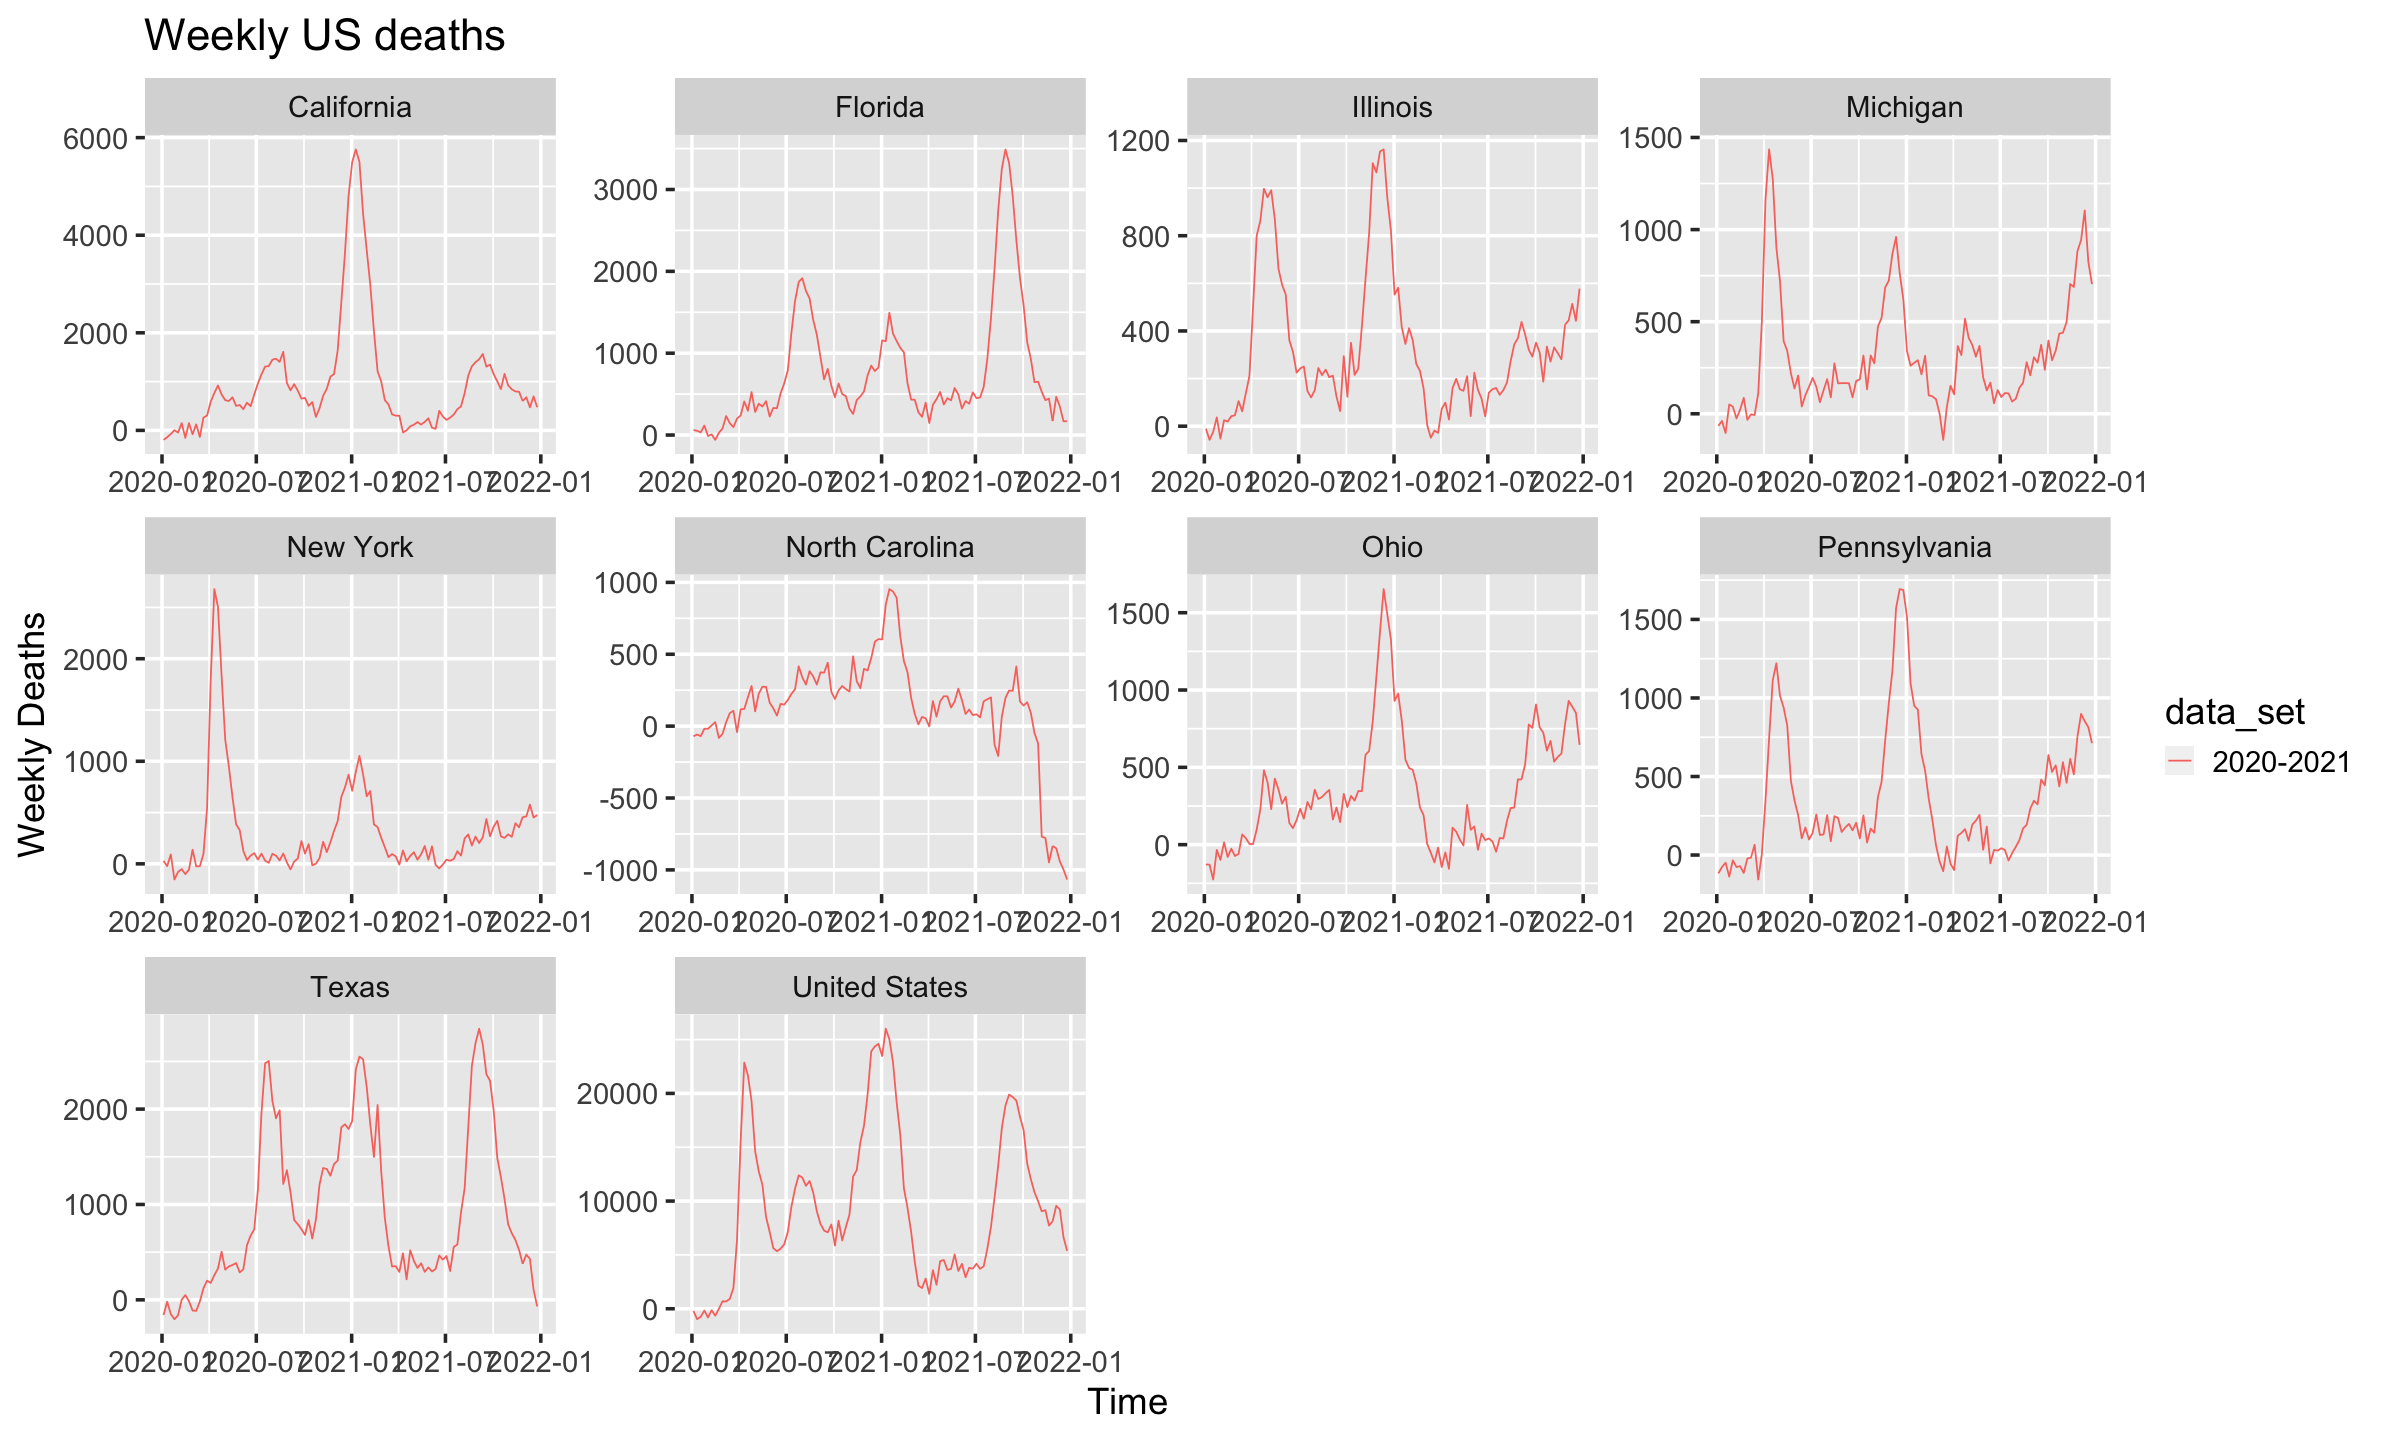

In [136]:
# Plot with quantile trend from 2014-2019
options(repr.plot.width=20, repr.plot.height=12)
b = ggplot(state_centered[state_centered$State %in% largest_ten & year(state_centered$Week.Ending.Date) > 2019,], 
           aes(x=Week.Ending.Date, y=detrended - median, color=data_set))
b + geom_line() + facet_wrap(~State, scales="free") +
theme_gray(base_size = 22) + 
labs(x = "Time", y = "Weekly Deaths", title="Weekly US deaths")

In [137]:
write.csv(state_centered, "../data/state_centered.csv")